In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
sns.set_style(style = "whitegrid")
train_path= "/Users/morenx/Downloads/titanic/train.csv"
test_path= "/Users/morenx/Downloads/titanic/test.csv"

In [9]:
titanic = pd.read_csv(train_path)
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


subplots para ver sobrevivientes dados ciertos atributos

/var/folders/lt/n0_y0qx173v13mss419tfhlm0000gn/T/ipykernel_22412/1544228020.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Survived", data=titanic,


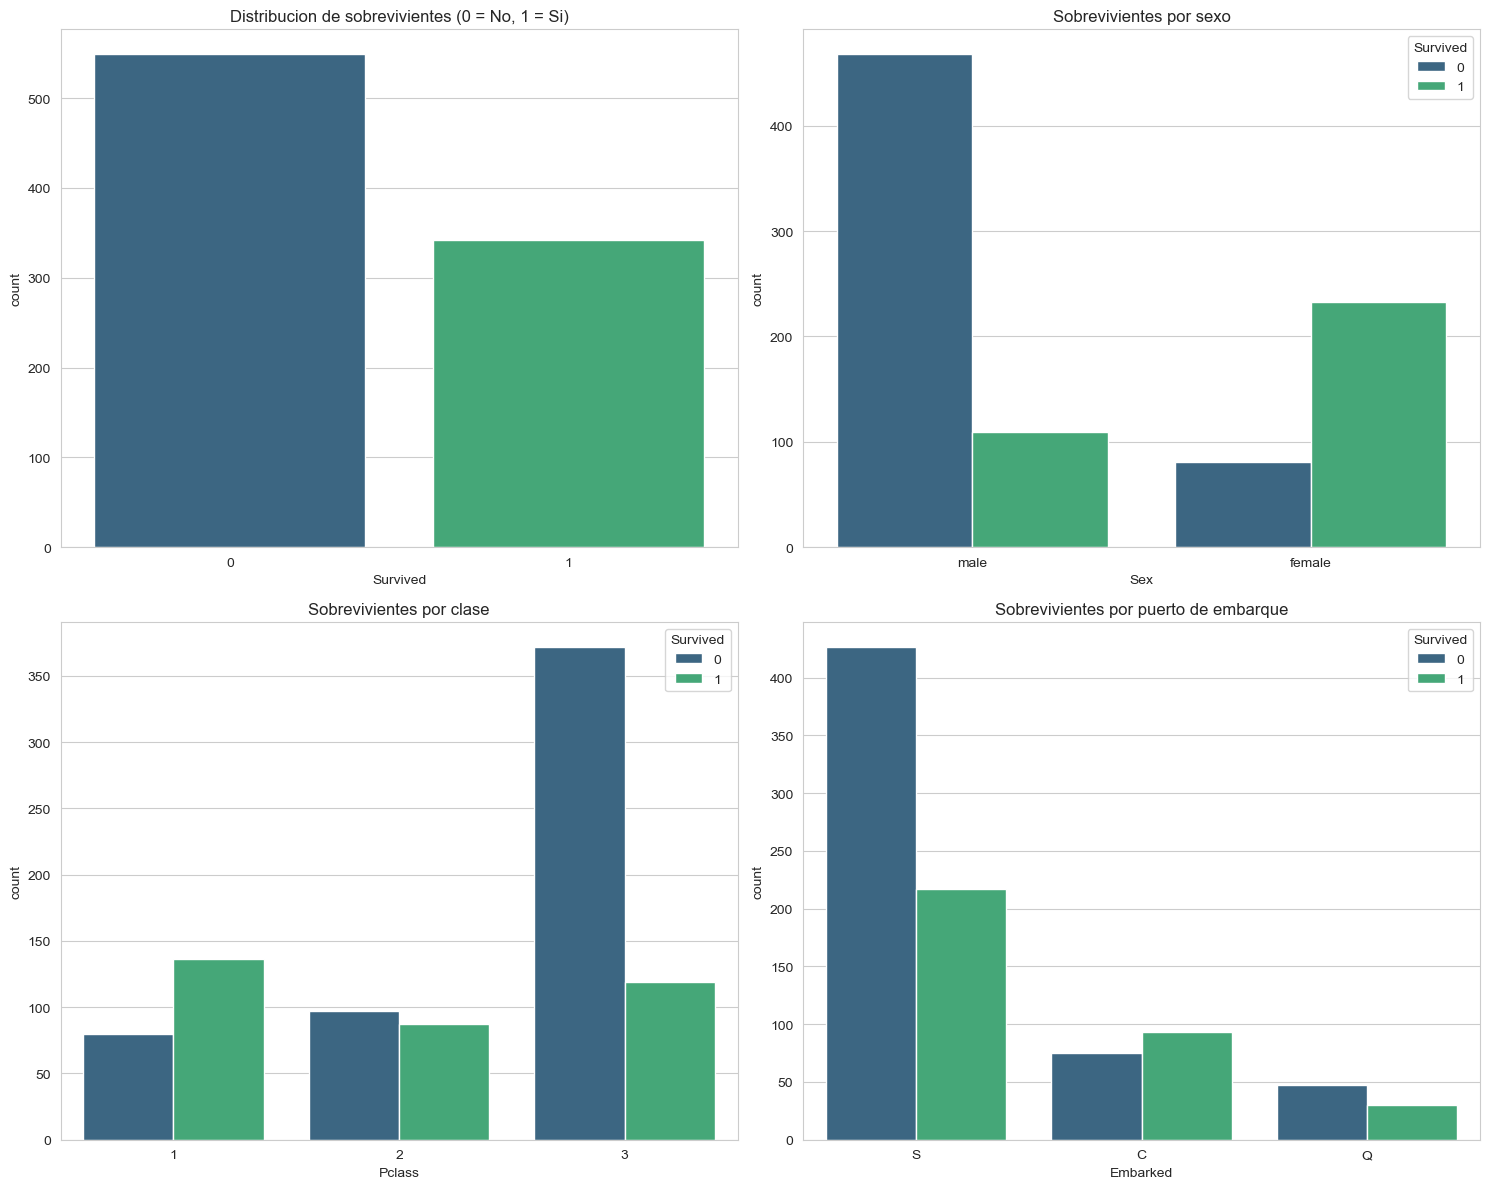

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
# 1. survival count
sns.countplot(x="Survived", data=titanic,
              ax=axes[0, 0],
              palette= "viridis")
axes[0, 0].set_title("Distribucion de sobrevivientes (0 = No, 1 = Si)")

# 2. survival by sex
sns.countplot(x="Sex", hue = "Survived", data=titanic,
              ax=axes[0, 1],
              palette= "viridis")
axes[0, 1].set_title("Sobrevivientes por sexo")

# 3. survival by pclass
sns.countplot(x="Pclass", hue = "Survived", data=titanic,
              ax=axes[1, 0],
              palette= "viridis")
axes[1, 0].set_title("Sobrevivientes por clase")

# 4 , survival by embarked 
sns.countplot(x="Embarked", hue = "Survived", data=titanic,
              ax=axes[1, 1],
              palette= "viridis")
axes[1, 1].set_title("Sobrevivientes por puerto de embarque")

plt.tight_layout()
            

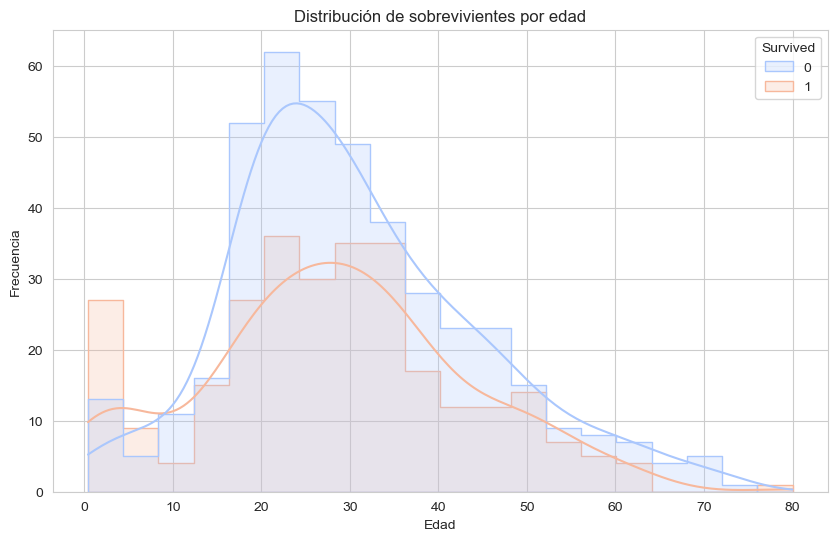

In [12]:
#distribucion de sobrevivientes por edad
plt.figure(figsize=(10, 6))
sns.histplot(x="Age", hue = "Survived", 
            data=titanic,element = "step" ,
            kde=True, palette= "coolwarm")
plt.title("Distribución de sobrevivientes por edad")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

matriz de correlacion

Text(0.5, 1.0, 'Matriz de correlacion de columnas numericas')

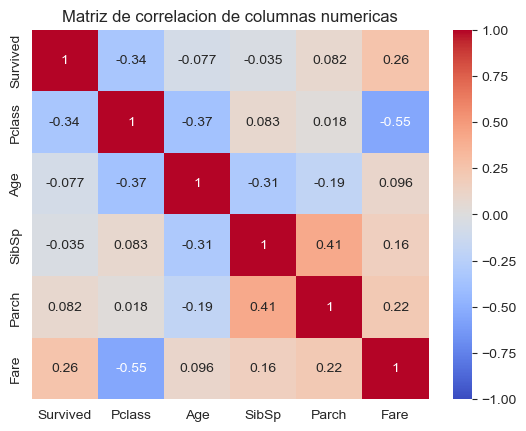

In [13]:
#matriz de correlacion
numeric_cols = titanic.select_dtypes(include=['float64', 'int64']).drop(['PassengerId'], axis=1)
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de correlacion de columnas numericas")

LIMPIEZA

In [16]:
#en los nulos de embarked se reemplaza con su mediana
titanic["Embarked"] = titanic["Embarked"].fillna(titanic["Embarked"].mode()[0])

#remplazo de nulos en Age (Mediana por Sexo y Clase)
age_medians = titanic.groupby(['Sex', 'Pclass'])['Age'].median()
titanic["Age"] = titanic["Age"].fillna(titanic.groupby(["Sex", "Pclass"])["Age"].transform("median"))

#eliminar columna ticket, no la considero relevante para el modelo
titanic.drop("Ticket", axis=1, inplace=True)

#experimento con columna cabin.
titanic['Has_Cabin'] = titanic['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

In [17]:
#null check
print("Conteo de nulos después de la limpieza:")
print(titanic.isnull().sum())

Conteo de nulos después de la limpieza:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Cabin          687
Embarked         0
Has_Cabin        0
dtype: int64


feature engineer

en la columna name viene un "marcador", mr : señor, mrs :señora, miss : joven niña, master : joven niño, los extraere para ver si tiene alguna correlacion con su sobrevivencia, lo mas probable que un joven de clase alta tuviera mas chanse de sobrevivir que un joven de clase baja.

In [20]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

titanic['Title'] = titanic['Name'].apply(get_title)

#agrupamos todods los titulos
titanic['Title'] = titanic['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic['Title'] = titanic['Title'].replace('Mlle', 'Miss')
titanic['Title'] = titanic['Title'].replace('Ms', 'Miss')
titanic['Title'] = titanic['Title'].replace('Mme', 'Mrs')

In [21]:
#etiqueta binria para ver si el pasajero iba solo o con familia
titanic ["FamilySize"] = titanic["SibSp"] + titanic["Parch"] + 1
titanic["IsAlone"] = 0
titanic.loc[titanic["FamilySize"] == 1, "IsAlone"] = 1

In [23]:
#interaccion clase x edad
titanic["Age_Class"] = titanic["Pclass"] * titanic["Age"]

#pago por persona
titanic["Fare_Per_Person"] = titanic["Fare"] / titanic ["FamilySize"]

In [24]:
#new features
print("Conteo de Títulos:")
print(titanic['Title'].value_counts())

print("\nRelación Título vs Supervivencia:")
print(titanic.groupby('Title')['Survived'].mean())

print("\nDataset con nuevas columnas (primeras 5 filas):")
print(titanic[['Name', 'Title', 'IsAlone', 'Age_Class', 'Fare_Per_Person']].head())

Conteo de Títulos:
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64

Relación Título vs Supervivencia:
Title
Master    0.575000
Miss      0.702703
Mr        0.156673
Mrs       0.793651
Rare      0.347826
Name: Survived, dtype: float64

Dataset con nuevas columnas (primeras 5 filas):
                                                Name Title  IsAlone  \
0                            Braund, Mr. Owen Harris    Mr        0   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...   Mrs        0   
2                             Heikkinen, Miss. Laina  Miss        1   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)   Mrs        0   
4                           Allen, Mr. William Henry    Mr        1   

   Age_Class  Fare_Per_Person  
0       66.0          3.62500  
1       38.0         35.64165  
2       78.0          7.92500  
3       35.0         26.55000  
4      105.0          8.05000  


selecciion de features a usar para nuestro modelo...

In [28]:
#guardamos passengerID para la entrega final de kaggle
passenger_id = titanic ["PassengerId"]

cols2drop = ["Name", "SibSp", "Parch", 
            "FamilySize", "Cabin", "PassengerId"]
titanic_final = titanic.drop(cols2drop, axis = 1)

#onehot encoder
titanic_final = pd.get_dummies(titanic_final, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

#view 
print(titanic_final.head())
print(titanic_final.columns.tolist())
print("Conteo de nulos después de la limpieza:")
print(titanic_final.isnull().sum())

   Survived  Pclass   Age     Fare  Has_Cabin  IsAlone  Age_Class  \
0         0       3  22.0   7.2500          0        0       66.0   
1         1       1  38.0  71.2833          1        0       38.0   
2         1       3  26.0   7.9250          0        1       78.0   
3         1       1  35.0  53.1000          1        0       35.0   
4         0       3  35.0   8.0500          0        1      105.0   

   Fare_Per_Person  Sex_male  Embarked_Q  Embarked_S  Title_Miss  Title_Mr  \
0          3.62500      True       False        True       False      True   
1         35.64165     False       False       False       False     False   
2          7.92500     False       False        True        True     False   
3         26.55000     False       False        True       False     False   
4          8.05000      True       False        True       False      True   

   Title_Mrs  Title_Rare  
0      False       False  
1       True       False  
2      False       False  
3       

escalado de variables

In [57]:
from sklearn.preprocessing import StandardScaler
#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
!pip install xgboost catboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
RANDOM_STATE = 42

baseline: regresion logistica

In [32]:
X = titanic_final.drop("Survived", axis = 1)
y = titanic_final["Survived"]

#pipeline (escala los datos y luego aplica el modelo)
pipeline_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(random_state = RANDOM_STATE))
])

#kfold con 5 pliegues
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_STATE)

metrics = ["accuracy", "f1"]
cv_results = cross_validate(pipeline_lr, X, y, cv=skf, scoring = metrics)

print(f"Accuracy promedio: {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"F1-Score promedio: {cv_results['test_f1'].mean():.4f}")

Accuracy promedio: 0.8170 (+/- 0.0174)
F1-Score promedio: 0.7574


con una precision de 81% y una std baja, podria indicar que el modelo es estable, y la ingenieria de caracteristicas ha funcionado, ahora seguiremos con esa "vara" para mejorarla.

svm...

In [ ]:
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability = True, random_state = 42))
])

svm_params = {
    'svm__C': [0.1, 1, 100],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1],
    'svm__kernel': ['rbf']
}

svm_grid = GridSearchCV(svm_pipeline, svm_params, cv=skf, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X, y)

print(f"Best Params: {svm_grid.best_params_}")
print(f"Best CV Accuracy: {svm_grid.best_score_:.4f}")

Best Params: {'svm__C': 1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Best CV Accuracy: 0.8249


Exception ignored in: <function ResourceTracker.__del__ at 0x104c01bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x102381bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1028fdbc0>
Traceback (most recent call last

randomforest....

In [ ]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=2,
    criterion='entropy',
    random_state=RANDOM_STATE
)
# train
rf_model.fit(X, y)

# pred
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')

print(f"CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

CV Accuracy: 0.8305 (+/- 0.0243)


xgboost

In [51]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    eval_metric='logloss'  
)
# train
xgb_model.fit(X, y)

# crossval
cv_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

print(f"XGBoost CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"CV Scores: {cv_scores}")

XGBoost CV Accuracy: 0.8249 (+/- 0.0275)
CV Scores: [0.83798883 0.79775281 0.84831461 0.78651685 0.85393258]


catboost.

In [60]:
catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    border_count=128,
    loss_function='Logloss',
    eval_metric='Accuracy',
    random_seed=RANDOM_STATE,
    verbose=100,  # Muestra progreso cada 100 iteraciones
    early_stopping_rounds=50,
)

catboost_model.fit(X, y)

cv_scores = cross_val_score(catboost_model, X, y, cv=5, scoring='accuracy')

print(f"CatBoost CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


0:	learn: 0.8069585	total: 7.02ms	remaining: 3.5s
100:	learn: 0.8900112	total: 270ms	remaining: 1.07s
200:	learn: 0.9169473	total: 530ms	remaining: 788ms
300:	learn: 0.9371493	total: 644ms	remaining: 426ms
400:	learn: 0.9584736	total: 930ms	remaining: 230ms
499:	learn: 0.9685746	total: 1.13s	remaining: 0us
0:	learn: 0.8160112	total: 2.49ms	remaining: 1.24s
100:	learn: 0.8876404	total: 134ms	remaining: 531ms
200:	learn: 0.9199438	total: 228ms	remaining: 340ms
300:	learn: 0.9452247	total: 311ms	remaining: 205ms
400:	learn: 0.9592697	total: 389ms	remaining: 96.1ms
499:	learn: 0.9691011	total: 470ms	remaining: 0us
0:	learn: 0.8078541	total: 872us	remaining: 435ms
100:	learn: 0.9130435	total: 76.1ms	remaining: 301ms
200:	learn: 0.9326788	total: 185ms	remaining: 276ms
300:	learn: 0.9663394	total: 291ms	remaining: 192ms
400:	learn: 0.9733520	total: 381ms	remaining: 94ms
499:	learn: 0.9789621	total: 470ms	remaining: 0us
0:	learn: 0.8008415	total: 1.01ms	remaining: 505ms
100:	learn: 0.8892006	t

mlp

In [59]:
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100, 50, 25),  # 3 hiden cells
        activation='relu',
        solver='adam',
        alpha=0.001,  # Regularización L2
        batch_size=32,
        learning_rate='adaptive',
        learning_rate_init=0.001,
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20,
        random_state=RANDOM_STATE,
        verbose=False
    ))
])

# train
mlp_pipeline.fit(X, y)

# cross val
cv_scores = cross_val_score(mlp_pipeline, X, y, cv=5, scoring='accuracy')

print(f"\nMLP CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


MLP CV Accuracy: 0.8216 (+/- 0.0318)


dejare de lado los algoritmos individuales, me ire por hacer ensambles

voting

In [61]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('catboost', catboost_model),
        ('mlp', mlp_pipeline)
    ],
    voting='soft', 
    weights=[2, 1, 2, 1]  
)

# train
ensemble.fit(X, y)

# Evaluar
cv_scores = cross_val_score(ensemble, X, y, cv=5, scoring='accuracy')
print(f"Ensemble CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

0:	learn: 0.8069585	total: 5.07ms	remaining: 2.53s
100:	learn: 0.8900112	total: 75.7ms	remaining: 299ms
200:	learn: 0.9169473	total: 153ms	remaining: 227ms
300:	learn: 0.9371493	total: 228ms	remaining: 151ms
400:	learn: 0.9584736	total: 301ms	remaining: 74.3ms
499:	learn: 0.9685746	total: 369ms	remaining: 0us
0:	learn: 0.8160112	total: 1.51ms	remaining: 755ms
100:	learn: 0.8876404	total: 70.9ms	remaining: 280ms
200:	learn: 0.9199438	total: 143ms	remaining: 213ms
300:	learn: 0.9452247	total: 219ms	remaining: 145ms
400:	learn: 0.9592697	total: 306ms	remaining: 75.5ms
499:	learn: 0.9691011	total: 397ms	remaining: 0us
0:	learn: 0.8078541	total: 1.42ms	remaining: 706ms
100:	learn: 0.9130435	total: 129ms	remaining: 509ms
200:	learn: 0.9326788	total: 248ms	remaining: 370ms
300:	learn: 0.9663394	total: 330ms	remaining: 218ms
400:	learn: 0.9733520	total: 482ms	remaining: 119ms
499:	learn: 0.9789621	total: 567ms	remaining: 0us
0:	learn: 0.8008415	total: 2.35ms	remaining: 1.17s
100:	learn: 0.8892

stacking

In [63]:
from sklearn.ensemble import StackingClassifier

stacking = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('catboost', catboost_model),
        ('mlp', mlp_pipeline)
    ],
    final_estimator=LogisticRegression(random_state=RANDOM_STATE),
    cv=5
)

stacking.fit(X, y)
cv_scores = cross_val_score(stacking, X, y, cv=5, scoring='accuracy')
print(f"Stacking CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

0:	learn: 0.8069585	total: 4.87ms	remaining: 2.43s
100:	learn: 0.8900112	total: 81.8ms	remaining: 323ms
200:	learn: 0.9169473	total: 161ms	remaining: 240ms
300:	learn: 0.9371493	total: 265ms	remaining: 175ms
400:	learn: 0.9584736	total: 364ms	remaining: 90ms
499:	learn: 0.9685746	total: 499ms	remaining: 0us
0:	learn: 0.8160112	total: 2.43ms	remaining: 1.21s
100:	learn: 0.8876404	total: 160ms	remaining: 630ms
200:	learn: 0.9199438	total: 284ms	remaining: 423ms
300:	learn: 0.9452247	total: 371ms	remaining: 245ms
400:	learn: 0.9592697	total: 447ms	remaining: 110ms
499:	learn: 0.9691011	total: 518ms	remaining: 0us
0:	learn: 0.8078541	total: 682us	remaining: 340ms
100:	learn: 0.9130435	total: 68.7ms	remaining: 271ms
200:	learn: 0.9326788	total: 139ms	remaining: 206ms
300:	learn: 0.9663394	total: 262ms	remaining: 173ms
400:	learn: 0.9733520	total: 369ms	remaining: 91ms
499:	learn: 0.9789621	total: 482ms	remaining: 0us
0:	learn: 0.8008415	total: 1.71ms	remaining: 854ms
100:	learn: 0.8892006	t

terminamos de entrenar modelos, usare el dataset test.csv para entregar mi reporte final

In [66]:
test = pd.read_csv(test_path)
test_ids = test['PassengerId']  #guardamos passengerid para la entrega

#limpieza
# Reemplazar nulos de Embarked con su mediana
test["Embarked"] = test["Embarked"].fillna(test["Embarked"].mode()[0])

# Reemplazar nulos en Age (Mediana por Sexo y Clase)
age_medians = test.groupby(['Sex', 'Pclass'])['Age'].median()
test["Age"] = test["Age"].fillna(test.groupby(["Sex", "Pclass"])["Age"].transform("median"))

# Eliminar columna Ticket (no relevante)
test.drop("Ticket", axis=1, inplace=True)

# Experimento con columna Cabin
test['Has_Cabin'] = test['Cabin'].apply(lambda x: 0 if pd.isna(x) else 1)

# feature engineer

# Función para extraer título
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

test['Title'] = test['Name'].apply(get_title)

# Agrupar todos los títulos
test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test['Title'] = test['Title'].replace('Mlle', 'Miss')
test['Title'] = test['Title'].replace('Ms', 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

# Etiqueta binaria para ver si el pasajero iba solo o con familia
test["FamilySize"] = test["SibSp"] + test["Parch"] + 1
test["IsAlone"] = 0
test.loc[test["FamilySize"] == 1, "IsAlone"] = 1

# Interacción clase x edad
test["Age_Class"] = test["Pclass"] * test["Age"]

# Pago por persona
test["Fare_Per_Person"] = test["Fare"] / test["FamilySize"]

# Llenar Fare nulos si existen
test["Fare_Per_Person"] = test["Fare_Per_Person"].fillna(test["Fare_Per_Person"].median())

# seleccion final de caracteristicas

# Columnas a eliminar
cols2drop = ["Name", "SibSp", "Parch", "FamilySize", "Cabin", "PassengerId"]
test_final = test.drop(cols2drop, axis=1)

# One-hot encoder
test_final = pd.get_dummies(test_final, columns=['Sex', 'Embarked', 'Title'], drop_first=True)

# Verificar que test_final tenga las MISMAS columnas que train
print("Columnas en test_final:")
print(test_final.columns.tolist())
print(f"\nTotal de columnas: {len(test_final.columns)}")
print(f"Nulos después de la limpieza:")
print(test_final.isnull().sum())




Columnas en test_final:
['Pclass', 'Age', 'Fare', 'Has_Cabin', 'IsAlone', 'Age_Class', 'Fare_Per_Person', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare']

Total de columnas: 14
Nulos después de la limpieza:
Pclass             0
Age                0
Fare               1
Has_Cabin          0
IsAlone            0
Age_Class          0
Fare_Per_Person    0
Sex_male           0
Embarked_Q         0
Embarked_S         0
Title_Miss         0
Title_Mr           0
Title_Mrs          0
Title_Rare         0
dtype: int64


In [67]:
# pred

predictions = ensemble.predict(test_final)

# 4DataFrame  submission
submission = pd.DataFrame({
    'PassengerId': passenger_id,
    'Survived': predictions
})
submission.to_csv('submission.csv', index=False)

print("\n submission.csv creado exitosamente!")
print(f"Total de predicciones: {len(submission)}")
print(f"\nPrimeras 10 filas:")
print(submission.head(10))

# Verificar distribución de predicciones
print(f"\nDistribución de predicciones:")
print(submission['Survived'].value_counts())
print(f"\nTasa de supervivencia predicha: {submission['Survived'].mean():.2%}")


ValueError: Input X contains NaN.
MLPClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values